# TP 1: Réseaux de neurones (1)

## 0. Introduction and préliminaires

Dans cette session, nous verrons des réseaux simples dense, dits "feed-forward" pour de la classification. 
Nous utiliserons le module Tensorflow et sa sous-partie Keras qui donne un accès de haut niveau aux éléments classiques d'une architecture de réseau de neurones.
On retrouvera matplotlib/pylab pour la visualisation. 


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
from tensorflow import keras


import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.3.0


## 1. Classifying handwritten digits (classification de chiffres manuscrits) 

Nous allons étudier le célèbre jeu de données MNIST, d'image de chiffres écrits à la main. 
Il contient 70000 instances de chiffres (0-9), dont 60000 réservés pour l'entrainement et 10000 pour le test. 

### Charger MNIST 
keras fournit une fonction spécialement dédiée:

In [3]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

Les données sont chargées dans des matrices numpy

* `train_images` et `train_labels` contient les données d'entrainement
* `test_images` et `test_labels` contient les données de test, pour évaluer les performances du modèel

Les images sont des matrices de 28x28 pixels avec une valeur entre 0 et 255. 

Les labels sont les entiers représentant les chiffres correspondant à chaque image. 


### Exploration des données
Regardons un peu ce qu'il y a dans les données :

In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
test_images.shape

(10000, 28, 28)

`train_images` est en fait un *tenseur*, un array numpy avec 3 axes, les 60000 instances de 28x28 valeurs, comme avoir un vecteur de matrices 28x28  


Par exemple, une image serait :

In [6]:
train_images[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

On voit que chaque pixel a une valeur entre 0 et 255. 

Pour chaque image, le vrai label est stocké avec le même indice dans `train_labels`

In [7]:
len(train_labels)

60000

Quel est le label de la première image ? 

In [8]:
train_labels[0]

5

### Prétraitements

Le code ci-dessous visualise la première image: 

In [9]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Il est généralement préférable de normaliser les scores entre [0,1]

On peut juste ici se contenter de diviser par le max théorique (255)


In [10]:
train_images = train_images / 255.0

test_images = test_images / 255.0

On peut vérifier ce que ça donne sur quelques images

In [11]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show()

### Définir le modèle

Définir un modèle comporte plusieurs étapes. 

La première est d'articuler les couches qui constituent l'architecture.

Keras fournit une construction de séquence avec la classe `Sequential`, qui permet de combiner les éléments: couches, fonctions d'activation ... en "cachant" les paramètres qui seront appris. 

Par exemple: 

In [12]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(2, activation='sigmoid'),
    keras.layers.Dense(10, activation='softmax')
])

L'étape de traitement Flatten transforme la matrice 28x28 en un seul vecteur de (28 * 28 = 784) valeurs. 

Ensuite on ajoute des couches complètement connectées ("Dense"), qui relie l'entrée, 768 valeurs pour la première, 
et qui sort 2 résultats, qui sert d'entrée à la couche suivante (la dernière), qui sort 10 valeurs. 
On ajoute à chaque fois une fonction d'activation sur chaque sortie. 

Le softmax ramène les valeurs entre 0 et 1 en sortie, valant 1 au total, comme une distribution de probabilités. 

Ensuite on définit un certains nombre de points qui permettent de compléter pour pouvoir entrainer le modèle:  

* **une loss**: la fonction de perte; ici on a un problème de classification donc nous prendrons l'entropie croisée (cross-entropy)
* **un optimiseur**: la procedure pour minimiser la loss, on prendra le plus simple (sgd = stochastic gradient descent). 
* **une métrique**: qui sert à évaluer le modèle au final. Ici on veut savoir la proportion d'images correctement classifiées ("accuracy"). 


In [13]:
# Stochastic Gradient Descent
sgd = tf.keras.optimizers.SGD(learning_rate=0.05)

model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'], )

### Entrainement 

Le modèle est compilé, et est prêt à être entrainé, en lui fournissant les données d'entrainement, avec la réponse attendue. 

La méthode pour entrainer le modèle s'appelle `fit`. 
Le modèle va voir chaque exemple plusieurs fois, à définir. On appelle "epoch" le fait d'avoir vu tous les exemples une fois. 
On spécifie donc le nombre d'epochs, ici 10, donc chaque exemple sera vu 10 fois.  

Un dernier paramètre est de dire combien d'exemples seront mis de côté pour surveiller les performances du modèle
au cours de l'entrainement (un jeu de validation, ou `validation split`).

Ici
`validation_split=0.1` dit à Keras de garder 10% du jeu de données pour validation.

Cela permet de surveiller par exemple l'overfitting. 

In [14]:
# Fonction pour l'affichage de l'historique des métriques d'apprentissage
def plot_history(history, val=False):
    plt.plot(history.history['accuracy'])
    if val:
        plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    if val:
        plt.legend(['train', 'val'], loc='upper left')
    else:
        plt.legend(['train'], loc='upper left')
    plt.show()

In [15]:
h = model.fit(train_images, train_labels, epochs=10, validation_split=0.1)

Epoch 1/10
1688/1688 [==============================] - 2s 1ms/step - loss: 1.9291 - accuracy: 0.3260 - val_loss: 1.6433 - val_accuracy: 0.3995
Epoch 2/10
1688/1688 [==============================] - 2s 1ms/step - loss: 1.5591 - accuracy: 0.3982 - val_loss: 1.4419 - val_accuracy: 0.4153
Epoch 3/10
1688/1688 [==============================] - 2s 1ms/step - loss: 1.4353 - accuracy: 0.4111 - val_loss: 1.3608 - val_accuracy: 0.4338
Epoch 4/10
1688/1688 [==============================] - 2s 1ms/step - loss: 1.3787 - accuracy: 0.4206 - val_loss: 1.3202 - val_accuracy: 0.4318
Epoch 5/10
1688/1688 [==============================] - 2s 1ms/step - loss: 1.3467 - accuracy: 0.4322 - val_loss: 1.2945 - val_accuracy: 0.4402
Epoch 6/10
1688/1688 [==============================] - 2s 1ms/step - loss: 1.3244 - accuracy: 0.4475 - val_loss: 1.2744 - val_accuracy: 0.4680
Epoch 7/10
1688/1688 [==============================] - 2s 1ms/step - loss: 1.3049 - accuracy: 0.4824 - val_loss: 1.2600 - val_accuracy:

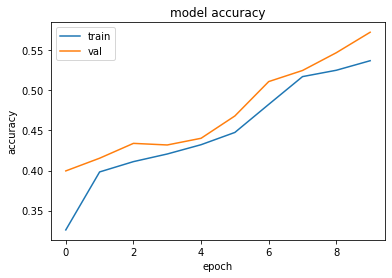

In [16]:
plot_history(h, val=True)

### Evaluation du modèle

Ensuite on vérifie la "vraie" performance une fois que l'entrainement est finie, sur les données de test. 

In [17]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
train_loss, train_acc = model.evaluate(train_images,  train_labels, verbose=2)

print('\nTest accuracy:', test_acc)
print('\nTrain accuracy:', train_acc)

313/313 - 0s - loss: 1.2395 - accuracy: 0.5460
1875/1875 - 2s - loss: 1.2414 - accuracy: 0.5485

Test accuracy: 0.5460000038146973

Train accuracy: 0.5485333204269409


### Faire des prédictions

On peut aussi utiliser le modèle pour faire des prédictions sur des images, ici voyons le résultat sur toutes les instances de test:

In [18]:
predictions = model.predict(test_images)

Si on regarde les prédictions pour la première image du test : 

In [19]:
predictions[0]

array([0.00944325, 0.00056777, 0.00044067, 0.00512978, 0.25702015,
       0.04855771, 0.00062527, 0.33974555, 0.01598688, 0.32248297],
      dtype=float32)

On voit la probabilité de chaque classe (donc d'être un numéro particulier). Pour trouver le meilleur on peut faire: 

In [20]:
np.argmax(predictions[0])

7

On peut vérifier que la réponse correspond au label attendu pour cet exemple : 

In [21]:
test_labels[0]

7

Voici une fonction pour afficher plus clairement le vecteur de probabilités : 

In [22]:
def plot_image(i, predictions_array, true_label, img, class_names=None):
    if class_names == None:
        class_names = range(len(predictions_array))
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


On peut regarder sur la première image. En bleu la décision du modèle en rouge la bonne réponse. 

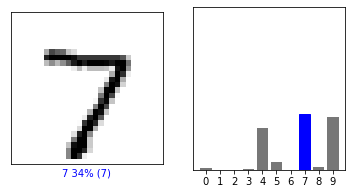

In [23]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()


La même chose pour 15 images. Pouvez vous voir si les erreurs sont cohérentes ? Si vous voyez pourquoi 

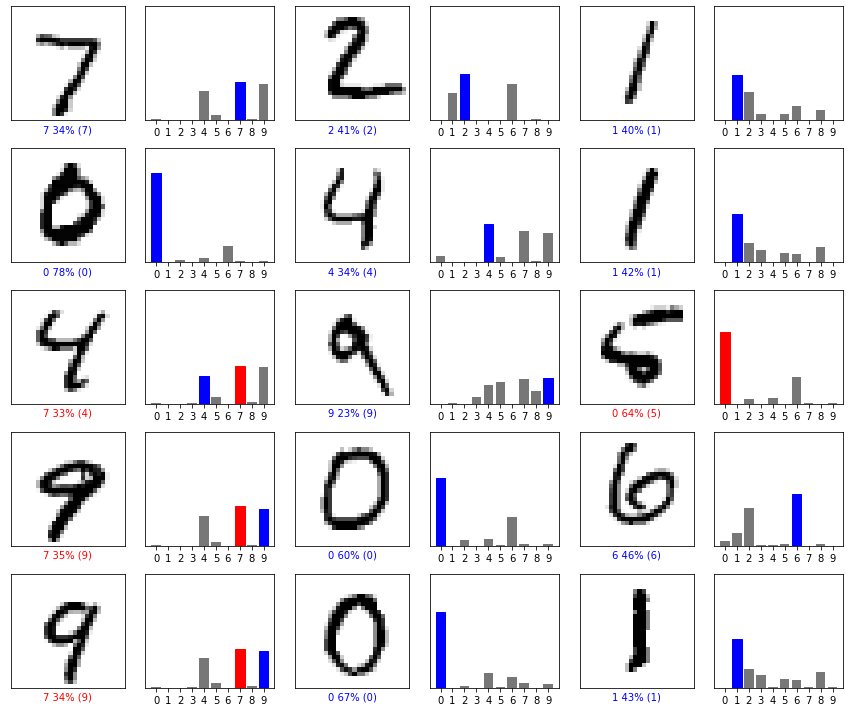

In [24]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()



### Exercices
* **Exercice 1**: Le modèle défini plus haut n'a qu'une couche cachée avec seulement deux neurones. Quelles sont les accuracies que vous obtenez sur le jeu d'entrainement ? sur le test ? Essayez d'augmenter le nombre de neurones pour voir l'influence de ce facteur. 

* **Exercice 2**: Il y a beaucoup de choix possibles pour la fonction d'activation. Regardez la documentation Keras (https://keras.io/api/layers/activations/) pour en essayer d'autres. Quelle est celle qui semble le mieux fonctionner ici ? 


* **Exercice 3**: On a vu en cours l'intérêt de régulariser le modèle, par exemple avec un "drop out", qui met au hasard à 0 un certain nombres de valeur pour éviter de trop spécialiser le modèle sur certains neurones.  Ajouter un drop out (https://keras.io/api/layers/regularization_layers/dropout/) à la première couche en donnant une probabilité de 0.5 (la moitié des neurones sont mis à 0 après un passage). 

* **Exercice 4**: Faites varier la procédure d'optimisation de la loss, en testant certaines possibilités de Keras (https://keras.io/api/optimizers/#available-optimizers). Qu'est-ce qui marche le mieux ? 


* **Exercise 5**: Essayez de changer le modèle en ajoutant une ou plusieurs couches. 


* **Exercise 6; bonus**: Dessinez votre propre chiffre, et utilisez votre modèle pour faire une prédiction. Il faut que l'image soit de la taille 28x28. Vous pouvez utiliser par exemeple https://www.pixilart.com/draw. 
Pour charger l'image utilisez la fonction `plt.imread`. L'image produite eest en RGBA, et donc l'array retourné de dimensions (28,28,4) matrix. Vous pouvez juste prendre le canal rouge avec les indices `[:,:,0]` et ensuite faire `image = np.expand_dims(image, axis=0)` pour passer l'image (28,28) en (1,28,28) qui est ce qu'attend la fonction `model.predict` (un vecteur d'image 28x28, ici de taille 1).

Epoch 1/10
1688/1688 [==============================] - 2s 1ms/step - loss: 1.9314 - accuracy: 0.3547 - val_loss: 1.6375 - val_accuracy: 0.3962
Epoch 2/10
1688/1688 [==============================] - 2s 1ms/step - loss: 1.5493 - accuracy: 0.4153 - val_loss: 1.4383 - val_accuracy: 0.4273
Epoch 3/10
1688/1688 [==============================] - 2s 1ms/step - loss: 1.4247 - accuracy: 0.4512 - val_loss: 1.3535 - val_accuracy: 0.4880
Epoch 4/10
1688/1688 [==============================] - 2s 1ms/step - loss: 1.3583 - accuracy: 0.4846 - val_loss: 1.2979 - val_accuracy: 0.4947
Epoch 5/10
1688/1688 [==============================] - 2s 1ms/step - loss: 1.3130 - accuracy: 0.5037 - val_loss: 1.2623 - val_accuracy: 0.5253
Epoch 6/10
1688/1688 [==============================] - 2s 1ms/step - loss: 1.2793 - accuracy: 0.5187 - val_loss: 1.2307 - val_accuracy: 0.5310
Epoch 7/10
1688/1688 [==============================] - 2s 1ms/step - loss: 1.2528 - accuracy: 0.5313 - val_loss: 1.2055 - val_accuracy:

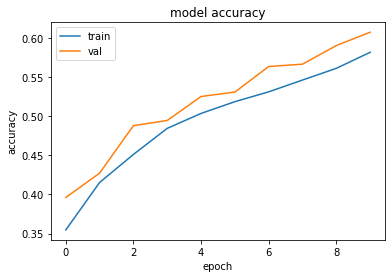

313/313 - 0s - loss: 1.1769 - accuracy: 0.5915

Test accuracy: 0.5914999842643738
Nb neurones : 5


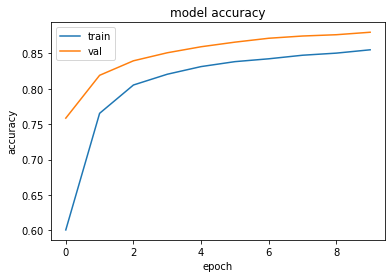

313/313 - 0s - loss: 0.4747 - accuracy: 0.8590

Test accuracy: 0.859000027179718
Nb neurones : 10


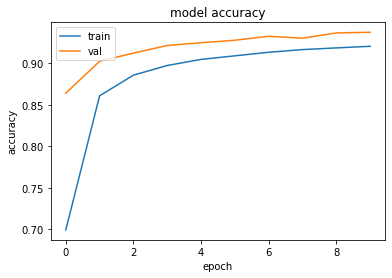

313/313 - 0s - loss: 0.2737 - accuracy: 0.9222

Test accuracy: 0.9222000241279602
Nb neurones : 20


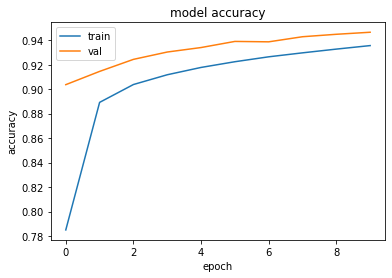

313/313 - 0s - loss: 0.2197 - accuracy: 0.9371

Test accuracy: 0.9370999932289124
Nb neurones : 50


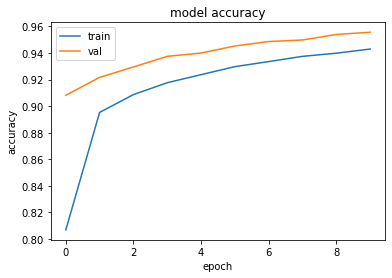

313/313 - 0s - loss: 0.1936 - accuracy: 0.9452

Test accuracy: 0.9452000260353088


In [25]:
## Exercice 1:
# On change le model en mettant + de neurones dans la couche cachée

nbNeuroness = [2, 5, 10, 20, 50]
models = []
hs = []
for nbNeurones in nbNeuroness :
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28, 28)),
        keras.layers.Dense(nbNeurones, activation='sigmoid'),
        keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'], )
    h = model.fit(train_images, train_labels, epochs=10, validation_split=0.1)
    models.append(model)
    hs.append(h)

for index, h in enumerate(hs):
    print("Nb neurones : " + str(nbNeuroness[index]))
    plot_history(h, val=True)

    test_loss, test_acc = models[index].evaluate(test_images,  test_labels, verbose=2)

    print('\nTest accuracy:', test_acc)

Epoch 1/10
1688/1688 [==============================] - 2s 1ms/step - loss: 1.5033 - accuracy: 0.4515 - val_loss: 1.2342 - val_accuracy: 0.5613
Epoch 2/10
1688/1688 [==============================] - 2s 1ms/step - loss: 1.2132 - accuracy: 0.5766 - val_loss: 1.1231 - val_accuracy: 0.6307
Epoch 3/10
1688/1688 [==============================] - 2s 1ms/step - loss: 1.1446 - accuracy: 0.6190 - val_loss: 1.0874 - val_accuracy: 0.6327
Epoch 4/10
1688/1688 [==============================] - 2s 1ms/step - loss: 1.1083 - accuracy: 0.6356 - val_loss: 1.0515 - val_accuracy: 0.6720
Epoch 5/10
1688/1688 [==============================] - 2s 1ms/step - loss: 1.0854 - accuracy: 0.6462 - val_loss: 1.0223 - val_accuracy: 0.6870
Epoch 6/10
1688/1688 [==============================] - 2s 1ms/step - loss: 1.0675 - accuracy: 0.6531 - val_loss: 0.9915 - val_accuracy: 0.6730
Epoch 7/10
1688/1688 [==============================] - 2s 1ms/step - loss: 1.0542 - accuracy: 0.6521 - val_loss: 0.9920 - val_accuracy:

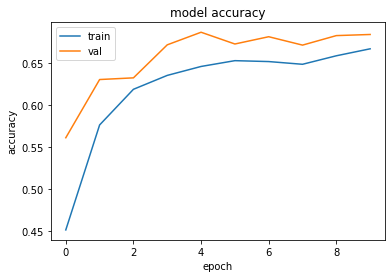

313/313 - 0s - loss: 1.0102 - accuracy: 0.6656

Test accuracy: 0.6656000018119812
Fonction : sigmoid


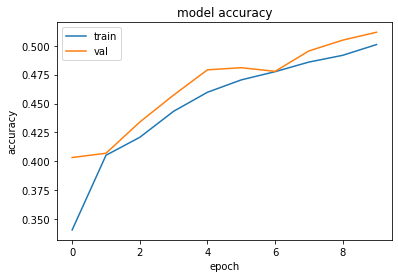

313/313 - 0s - loss: 1.1956 - accuracy: 0.4904

Test accuracy: 0.4903999865055084
Fonction : softmax


313/313 - 0s - loss: 1.6994 - accuracy: 0.2934

Test accuracy: 0.29339998960494995
Fonction : softplus


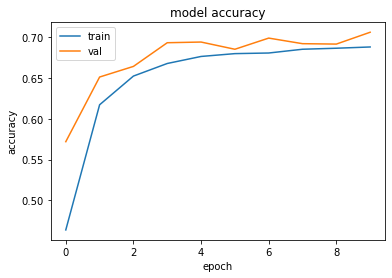

313/313 - 0s - loss: 0.9843 - accuracy: 0.6893

Test accuracy: 0.689300000667572
Fonction : softsign


313/313 - 0s - loss: 1.1629 - accuracy: 0.5993

Test accuracy: 0.5993000268936157
Fonction : tanh


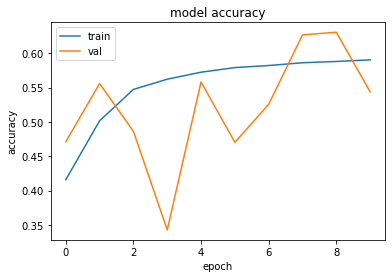

313/313 - 0s - loss: 1.2923 - accuracy: 0.5383

Test accuracy: 0.5382999777793884
Fonction : selu


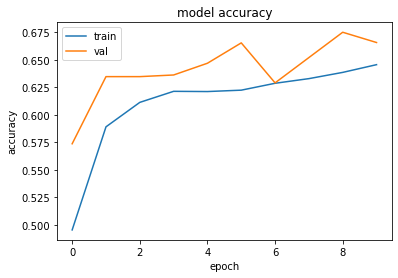

313/313 - 0s - loss: 1.0610 - accuracy: 0.6492

Test accuracy: 0.6492000222206116
Fonction : elu


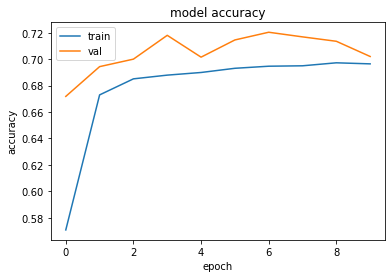

313/313 - 0s - loss: 1.0123 - accuracy: 0.6827

Test accuracy: 0.682699978351593
Fonction : exponential


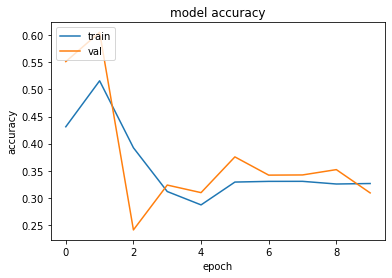

313/313 - 0s - loss: 1.9358 - accuracy: 0.3027

Test accuracy: 0.302700012922287


In [26]:
## Exercice 2
fonctions = ["relu", "sigmoid", "softmax", "softplus", "softsign", "tanh", "selu", "elu", "exponential"]
models = []
hs = []
for fonction in fonctions :
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28, 28)),
        keras.layers.Dense(2, activation=fonction),
        keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=sgd,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'], )
    h = model.fit(train_images, train_labels, epochs=10, validation_split=0.1)
    models.append(model)
    hs.append(h)

for index, h in enumerate(hs):
    print("Fonction : " + str(fonctions[index]))
    plot_history(h, val=True)

    test_loss, test_acc = models[index].evaluate(test_images,  test_labels, verbose=2)

    print('\nTest accuracy:', test_acc)

Epoch 1/10
1688/1688 [==============================] - 3s 2ms/step - loss: 1.9347 - accuracy: 0.2846 - val_loss: 1.7025 - val_accuracy: 0.3598
Epoch 2/10
1688/1688 [==============================] - 3s 2ms/step - loss: 1.6181 - accuracy: 0.3820 - val_loss: 1.5085 - val_accuracy: 0.4247
Epoch 3/10
1688/1688 [==============================] - 3s 2ms/step - loss: 1.5021 - accuracy: 0.4064 - val_loss: 1.4304 - val_accuracy: 0.4287
Epoch 4/10
1688/1688 [==============================] - 3s 1ms/step - loss: 1.4506 - accuracy: 0.4166 - val_loss: 1.3898 - val_accuracy: 0.4415
Epoch 5/10
1688/1688 [==============================] - 2s 1ms/step - loss: 1.4192 - accuracy: 0.4285 - val_loss: 1.3633 - val_accuracy: 0.4607
Epoch 6/10
1688/1688 [==============================] - 3s 2ms/step - loss: 1.3965 - accuracy: 0.4413 - val_loss: 1.3427 - val_accuracy: 0.4680
Epoch 7/10
1688/1688 [==============================] - 3s 2ms/step - loss: 1.3756 - accuracy: 0.4516 - val_loss: 1.3204 - val_accuracy:

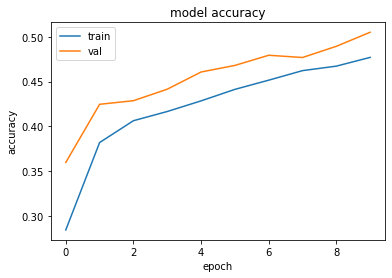

313/313 - 0s - loss: 1.2956 - accuracy: 0.4816

Test accuracy: 0.48159998655319214
Rate : 0.5


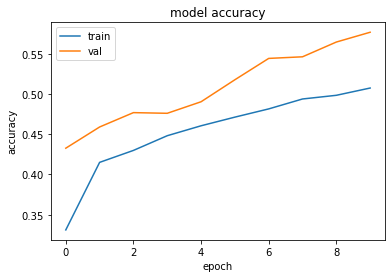

313/313 - 0s - loss: 1.2222 - accuracy: 0.5763

Test accuracy: 0.5763000249862671
Rate : 0.8


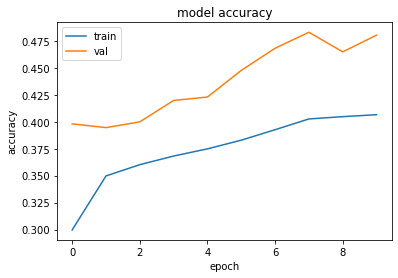

313/313 - 0s - loss: 1.3736 - accuracy: 0.4746

Test accuracy: 0.4745999872684479


In [27]:
## Exercice 3: On a vu en cours l’intérêt de régulariser le modèle, par exemple avec un “drop out”, qui met au hasard à 0 un certain nombres de valeur pour éviter de trop spécialiser le modèle sur certains neurones. Ajouter un drop out (https://keras.io/api/layers/regularization_layers/dropout/) à la première couche en donnant une probabilité de 0.5 (la moitié des neurones sont mis à 0 après un passage).

## Exercice 3
rates = [.1, .5, .8]
models = []
hs = []
for rate in rates :
    # layer = keras.layers.Dropout(rate, input_shape=(28, 28))
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28, 28)),
        keras.layers.Dropout(rate),
        keras.layers.Dense(2, activation='sigmoid'),
        keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=sgd,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    h = model.fit(train_images, train_labels, epochs=10, validation_split=0.1)
    models.append(model)
    hs.append(h)

for index, h in enumerate(hs):
    print("Rate : " + str(rates[index]))
    plot_history(h, val=True)

    test_loss, test_acc = models[index].evaluate(test_images,  test_labels, verbose=2)

    print('\nTest accuracy:', test_acc)

In [28]:
#Exercice 4: Faites varier la procédure d'optimisation de la loss, en testant certaines possibilités de Keras (https://keras.io/api/optimizers/#available-optimizers). Qu'est-ce qui marche le mieux ?

optimizers = ["SGD", "RMSprop", "Adam", "Adadelta", "Adagrad", "Adamax", "Nadam", "Ftrl"]
models = []
hs = []
for opt in optimizers :
    # layer = keras.layers.Dropout(rate, input_shape=(28, 28))
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(28, 28)),
        keras.layers.Dense(2, activation='sigmoid'),
        keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    h = model.fit(train_images, train_labels, epochs=10, validation_split=0.1)
    models.append(model)
    hs.append(h)

for index, h in enumerate(hs):
    print("Optimizer : " + str(optimizers[index]))
    plot_history(h, val=True)

    test_loss, test_acc = models[index].evaluate(test_images,  test_labels, verbose=2)

    print('\nTest accuracy:', test_acc)

Epoch 1/10
1688/1688 [==============================] - 2s 1ms/step - loss: 2.2254 - accuracy: 0.1726 - val_loss: 2.1408 - val_accuracy: 0.2493
Epoch 2/10
1688/1688 [==============================] - 2s 995us/step - loss: 2.0789 - accuracy: 0.3118 - val_loss: 1.9890 - val_accuracy: 0.3608
Epoch 3/10
1688/1688 [==============================] - 2s 963us/step - loss: 1.9393 - accuracy: 0.3672 - val_loss: 1.8587 - val_accuracy: 0.3635
Epoch 4/10
1688/1688 [==============================] - 2s 1ms/step - loss: 1.8243 - accuracy: 0.3761 - val_loss: 1.7537 - val_accuracy: 0.3798
Epoch 5/10
1688/1688 [==============================] - 2s 1ms/step - loss: 1.7312 - accuracy: 0.3913 - val_loss: 1.6676 - val_accuracy: 0.3992
Epoch 6/10
1688/1688 [==============================] - 2s 1ms/step - loss: 1.6565 - accuracy: 0.3961 - val_loss: 1.5985 - val_accuracy: 0.4015
Epoch 7/10
1688/1688 [==============================] - 2s 1ms/step - loss: 1.5980 - accuracy: 0.3978 - val_loss: 1.5438 - val_accur

KeyboardInterrupt: 

In [ ]:
## Exercise 6:
## à vous de jouer


## 2. Reconnaissance d’objets

### Les données CIFAR10 

Le jeu de données cifar10 contient 60000 instances d'images représentant 10 classes d'objets, avec leur label. Keras permet de le charger directement : 

In [ ]:
(train_images2, train_labels2), (test_images2, test_labels2) = keras.datasets.cifar10.load_data()

Les labels sont codés un peu différemment. Pour avoir un seul vecteur de labels, on va d'abord aplatir les vecteurs donnés. 

In [ ]:
train_labels2 = train_labels2.flatten()
test_labels2 = test_labels2.flatten()

Chaque classe est représentée par un nombre, on va donc leur associer un nom. 

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Voilà comment afficher les premières images de la base: 

In [ ]:
train_labels2 = train_labels2.flatten()
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images2[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels2[i]])
plt.show()

### Exercices

* **Exercice 7**: Définissez une architecture de reconnaissance d'objets pour CIFAR en vous inspirant de ce que vous avez fait pour MNIST, toujours `Sequential`. Compilez le modèle avec une loss, un optimiseur et une métrique. Faites variez les paramètres pour obtenir le meilleur résultat que vous pouvez. Vous pouvez encore utiliser `plot_image` et `plot_value_array` définies plus haut pour explorer les prédictions du modèle sur une seule image. 

In [ ]:
## Exercice 7

## à vous ...

model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(2, activation='sigmoid'),
    keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
h = model.fit(train_images2, train_labels2, epochs=10, validation_split=0.1)


plot_history(h, val=True)

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
predictions = model.predict(test_images2)

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels2, test_images2)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels2)
plt.tight_layout()
plt.show()